In [1]:
import re
import json
import torch
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, GenerationConfig

from sklearn.preprocessing import MinMaxScaler

from utilsforecast.losses import mae, smape
from utilsforecast.evaluation import evaluate

import warnings
warnings.filterwarnings('ignore')

D:\Anaconda\envs\book-env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
plt.rcParams.update({'font.size': 14})

In [3]:
data = pd.read_csv('../data/walmart_sales_small.csv', parse_dates=['Date'])
data.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,2010-02-05,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,2010-02-12,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,2010-02-26,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,2010-03-05,1554806.68,0,46.50,2.625,211.350143,8.106


In [4]:
model_name = "google/flan-t5-base"
flant5_model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
flant5_tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)

In [5]:
def llm_forecast(
    df,
    model,
    tokenizer,
    horizon,
    context_len,
    target_col,
    max_new_tokens=100,
    temperature=1.0
):
    scaler = MinMaxScaler(feature_range=(0, 1))
    
    all_values = df[target_col].values.reshape(-1, 1)
    scaler.fit(all_values)
    
    context_values = df[target_col].tail(context_len).values.reshape(-1, 1)
    scaled_context_values = scaler.transform(context_values).flatten()

    few_shot_examples = """
    Input: The last 8 scaled values of Weekly_Sales were 0.5283317 , 0.58826193, 0.71939157, 0.95514386, 0.43612893, 0.45639017, 0.45729709, 0.46355804. What will be the next values?
    Output: 0.53329332, 0.55390031, 0.59245479, 0.52100866, 0.52860909, 0.50953767, 0.53251093
    """
    
    values_str = ", ".join(map(lambda x: f"{x:.4f}", scaled_context_values))
    
    prompt = f"""
    {few_shot_examples}
    Input: The last {context_len} scaled values of {target_col} were {values_str}.
    What will be the next {horizon} scaled values? Remember to provide exactly {horizon} comma-separated numbers between 0 and 1.
    """
    
    prompt += "\nOutput:"
    
    inputs = tokenizer(prompt, return_tensors='pt')
    with torch.no_grad():
        output = tokenizer.decode(
            model.generate(
                inputs["input_ids"],
                max_new_tokens=max_new_tokens,
                temperature=temperature
            )[0],
            skip_special_tokens=True
        )
    print("Raw model output:", output)
    output = output.rstrip('.')
    
    try:
        scaled_preds = [float(x.strip()) for x in output.split(',') if x.strip()]
    except ValueError:
        print(f"Warning: Could not convert all outputs to float. Using only valid floats.")
        scaled_preds = [float(x.strip()) for x in output.split(',') if x.strip() and x.replace('.', '').isdigit()]
    
    if len(scaled_preds) < horizon:
        print(f"Warning: Did not generate enough predictions. Only generated {len(scaled_preds)} out of {horizon}")
        last_valid = scaled_preds[-1] if scaled_preds else 0.5  # Use 0.5 if no valid predictions
        scaled_preds.extend([last_valid] * (horizon - len(scaled_preds)))
    elif len(scaled_preds) > horizon:
        scaled_preds = scaled_preds[:horizon]
    
    scaled_preds = np.clip(scaled_preds, 0, 1)
    
    preds = scaler.inverse_transform(np.array(scaled_preds).reshape(-1, 1)).flatten()
    
    return preds.tolist()

## Zero-shot forecasting

In [6]:
store1_t5_preds = llm_forecast(data.query("Store == 1"),
                                  model=flant5_model,
                                  tokenizer=flant5_tokenizer,
                                  horizon=8,
                                  context_len=8,
                                  target_col='Weekly_Sales')

store2_t5_preds = llm_forecast(data.query("Store == 2"),
                                  model=flant5_model,
                                  tokenizer=flant5_tokenizer,
                                  horizon=8,
                                  context_len=8,
                                  target_col='Weekly_Sales')

store3_t5_preds = llm_forecast(data.query("Store == 3"),
                                  model=flant5_model,
                                  tokenizer=flant5_tokenizer,
                                  horizon=8,
                                  context_len=8,
                                  target_col='Weekly_Sales')

store4_t5_preds = llm_forecast(data.query("Store == 4"),
                                  model=flant5_model,
                                  tokenizer=flant5_tokenizer,
                                  horizon=8,
                                  context_len=8,
                                  target_col='Weekly_Sales')

Raw model output: 0.2872, 0.2872, 0.2872, 0.2872, 0.2872, 0.2872
Raw model output: 0.1389, 0.1389, 0.1389, 0.1389, 0.1389, 0.1389
Raw model output: 0.2576, 0.2552, 0.2808, 0.2808, 0.2808, 0.2808
Raw model output: 0.1936, 0.1936, 0.1936, 0.1936, 0.1936


In [7]:
def combine_predictions(
    predictions,
    start_date,
    horizon,
    freq,
    model_name
):
    date_range = pd.date_range(start=start_date, periods=horizon, freq=freq)
    
    data = []
    
    for store_id, store_predictions in enumerate(predictions, start=1):
        for date, prediction in zip(date_range, store_predictions):
            data.append({
                'Store': store_id,
                'Date': date,
                f"{model_name}": prediction
            })
    
    df = pd.DataFrame(data)
    df = df.sort_values(['Store', 'Date'])
    
    return df

In [8]:
all_preds = [store1_t5_preds, store2_t5_preds, store3_t5_preds, store4_t5_preds]

preds_df = combine_predictions(all_preds,
                              start_date='11-02-2012',
                               horizon=8,
                               freq='W-FRI',
                               model_name="FlanT5")

preds_df.head()

,Store,Date,FlanT5
0,1,2012-11-02,1.624505e+06
1,1,2012-11-09,1.624505e+06
2,1,2012-11-16,1.624505e+06
3,1,2012-11-23,1.624505e+06
4,1,2012-11-30,1.624505e+06


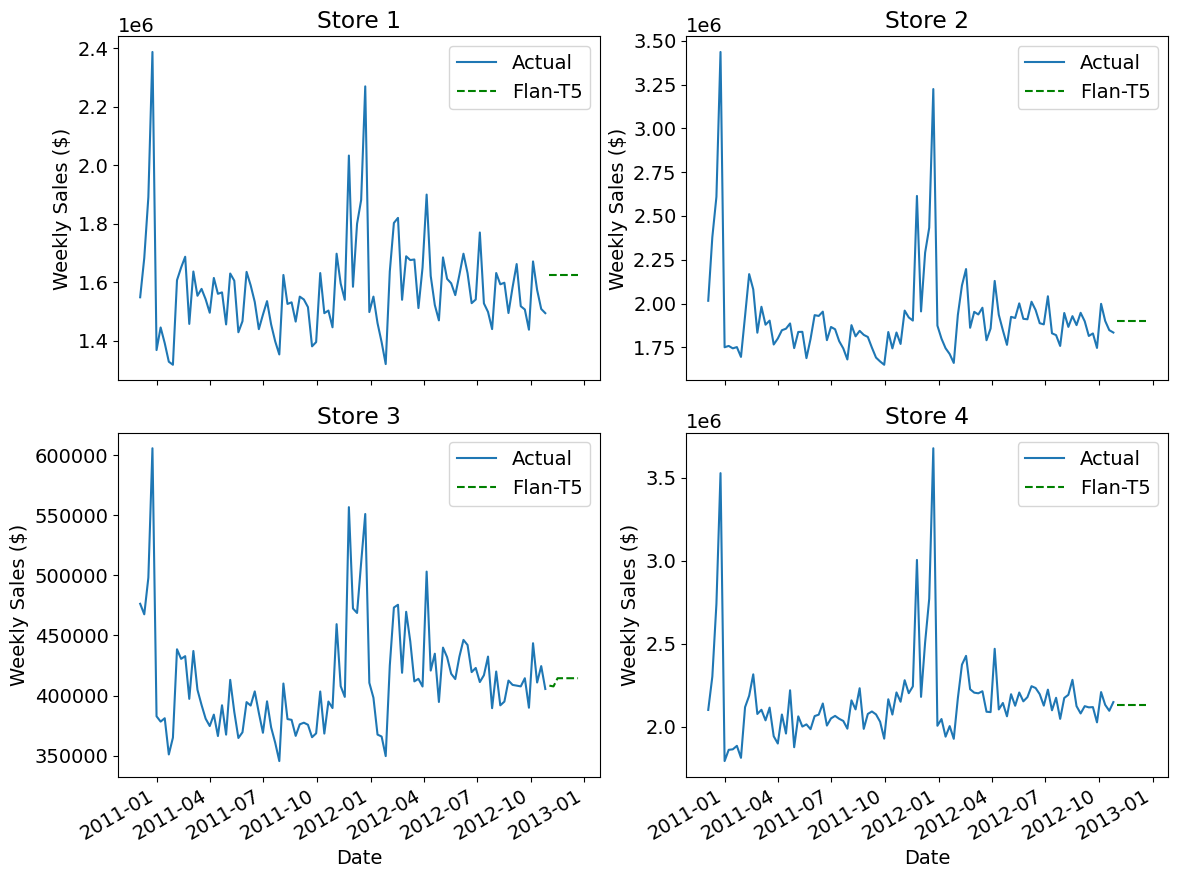

In [9]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,9))

plot_df = data.reset_index(drop=False).copy()
plot_preds_df = preds_df.copy()

for i, ax in enumerate(axes.flatten()):
    df = plot_df[plot_df['Store'] == i+1].iloc[-100:]
    preds_df = plot_preds_df[plot_preds_df['Store'] == i+1]

    ax.plot(df['Date'], df['Weekly_Sales'], label='Actual')
    ax.plot(preds_df['Date'], preds_df['FlanT5'], 'g--', label='Flan-T5')
    ax.legend()
    ax.set_title(f'Store {i+1}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Weekly Sales ($)')

fig.autofmt_xdate()
plt.tight_layout()
plt.savefig("figures/CH08_F03_peixeiro2.png", dpi=300)

## Cross-validation

In [10]:
def cross_validation_llm(df, h, n_windows, target_col, model, tokenizer):

    preds = []
    
    for i in range(n_windows, 0, -1):
        input_df = df.iloc[:-(h * i)]
        
        forecast = llm_forecast(input_df,
                                model=model,
                                tokenizer=tokenizer,
                                horizon=h,
                                context_len=h,
                                target_col=target_col)
    
        preds.extend(forecast)

    return preds

In [11]:
store1_cv = cross_validation_llm(data.query("Store == 1"),
                                h=8,
                                n_windows=4,
                                target_col='Weekly_Sales',
                                model=flant5_model,
                                tokenizer=flant5_tokenizer)

Raw model output: 0.2982, 0.4534, 0.4696, 0.2077, 0.3347
Raw model output: 0.1911, 0.1911, 0.3432, 0.2747
Raw model output: 0.2872, 0.2872, 0.2929, 0.1970, 0.2087
Raw model output: 0.1989, 0.1989, 0.1989, 0.1989, 0.1989, 0.1989


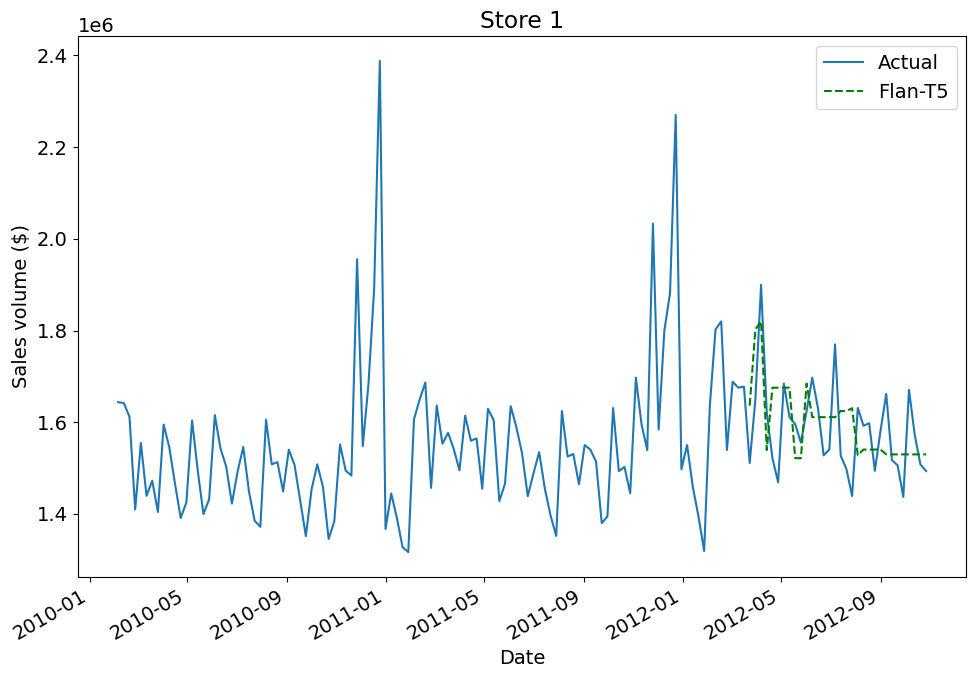

In [12]:
store1_df = data.query("Store == 1")

fig, ax = plt.subplots(figsize=(10,7))

ax.plot(store1_df['Date'], store1_df['Weekly_Sales'], label='Actual')
ax.plot(store1_df['Date'].iloc[-32:], store1_cv, ls='--', color='green', label='Flan-T5')

ax.set_title(f"Store 1")
ax.set_xlabel('Date')
ax.set_ylabel('Sales volume ($)')
ax.legend(loc=1)

fig.autofmt_xdate()
plt.tight_layout()

plt.savefig("figures/CH08_F04_peixeiro2.png", dpi=300)

In [13]:
test_df = data.query("Store == 1").iloc[-32:]
test_df['FlanT5'] = store1_cv

evaluation = evaluate(
    test_df,
    metrics=[mae, smape],
    models=['FlanT5'],
    target_col='Weekly_Sales',
    id_col='Store'
)

evaluation

,Store,metric,FlanT5
0,1,mae,83721.758963
1,1,smape,0.026251


## Using exogenous features

In [14]:
def llm_forecast(
    df,
    model,
    tokenizer,
    horizon,
    context_len,
    target_col,
    future_exog,
    max_new_tokens=100,
    temperature=1.0
):
    scaler = MinMaxScaler(feature_range=(0, 1))
    
    all_values = df[target_col].values.reshape(-1, 1)
    scaler.fit(all_values)
    
    context_values = df[target_col].tail(context_len).values.reshape(-1, 1)
    scaled_context_values = scaler.transform(context_values).flatten()

    few_shot_examples = """
    Input: The last 8 scaled values of Weekly_Sales were 0.5283317 , 0.58826193, 0.71939157, 0.95514386, 0.43612893, 0.45639017, 0.45729709, 0.46355804.
    The last values for Holiday_Flag were 0, 1, 0, 0, 0, 0, 0, 0. What will be the next values of Weekly_Sales knowing the next values of Holiday_Flag
    are 0, 0, 0, 0, 0, 0, 0, 0
    Output: 0.53329332, 0.55390031, 0.59245479, 0.52100866, 0.52860909, 0.50953767, 0.53251093
    """
    
    values_str = ", ".join(map(lambda x: f"{x:.4f}", scaled_context_values))
    
    prompt = f"""
    {few_shot_examples}
    Input: The last {context_len} scaled values of {target_col} were {values_str}.
    What will be the next {horizon} scaled values knowing the next values of Holiday_Flag are {future_exog}? Remember to provide exactly {horizon} comma-separated numbers between 0 and 1.
    """
    
    prompt += "\nOutput:"
    
    inputs = tokenizer(prompt, return_tensors='pt')
    with torch.no_grad():
        output = tokenizer.decode(
            model.generate(
                inputs["input_ids"],
                max_new_tokens=max_new_tokens,
                temperature=temperature
            )[0],
            skip_special_tokens=True
        )
    print("Raw model output:", output)
    output = output.rstrip('.')
    
    try:
        scaled_preds = [float(x.strip()) for x in output.split(',') if x.strip()]
    except ValueError:
        print(f"Warning: Could not convert all outputs to float. Using only valid floats.")
        scaled_preds = [float(x.strip()) for x in output.split(',') if x.strip() and x.replace('.', '').isdigit()]
    
    if len(scaled_preds) < horizon:
        print(f"Warning: Did not generate enough predictions. Only generated {len(scaled_preds)} out of {horizon}")
        last_valid = scaled_preds[-1] if scaled_preds else 0.5  # Use 0.5 if no valid predictions
        scaled_preds.extend([last_valid] * (horizon - len(scaled_preds)))
    elif len(scaled_preds) > horizon:
        scaled_preds = scaled_preds[:horizon]
    
    scaled_preds = np.clip(scaled_preds, 0, 1)
    
    preds = scaler.inverse_transform(np.array(scaled_preds).reshape(-1, 1)).flatten()
    
    return preds.tolist()

In [15]:
def values_to_str(df, column_name):
    # Get the last 32 values
    last_values = df[column_name].tail(32).values
    
    # Split into 4 chunks of 8 values each
    chunk1 = last_values[0:8]
    chunk2 = last_values[8:16]
    chunk3 = last_values[16:24]
    chunk4 = last_values[24:32]
    
    # Convert each chunk to a comma-separated string
    string1 = ", ".join(map(str, chunk1))
    string2 = ", ".join(map(str, chunk2))
    string3 = ", ".join(map(str, chunk3))
    string4 = ", ".join(map(str, chunk4))
    
    return string1, string2, string3, string4

hf1, hf2, hf3, hf4 = values_to_str(data, 'Holiday_Flag')

future_exog_dict = {0: hf1, 1:hf2, 2:hf3, 3:hf4}

future_exog_dict

{0: '0, 0, 0, 0, 0, 0, 0, 0',
 1: '0, 0, 0, 0, 0, 0, 0, 0',
 2: '0, 0, 0, 0, 0, 0, 0, 0',
 3: '1, 0, 0, 0, 0, 0, 0, 0'}

In [16]:
def cross_validation_llm_exog(df, h, n_windows, target_col, model, tokenizer):

    preds = []
    
    for i in range(n_windows, 0, -1):
        input_df = df.iloc[:-(h * i)]
        window_idx = n_windows - i
        
        forecast = llm_forecast(input_df,
                                model=model,
                                tokenizer=tokenizer,
                                horizon=h,
                                context_len=h,
                                target_col=target_col,
                                future_exog=future_exog_dict[window_idx])
    
        preds.extend(forecast)

    return preds

In [17]:
store1_cv_exog = cross_validation_llm_exog(data.query("Store == 1"),
                                h=8,
                                n_windows=4,
                                target_col='Weekly_Sales',
                                model=flant5_model,
                                tokenizer=flant5_tokenizer)

Raw model output: 0.0023, 0.2982, 0.4534, 0.4696, 0.2077, 0.3469, 0.3347
Raw model output: 0.53329332, 0.2840, 0.1911, 0.1419, 0.3432, 0.2747
Raw model output: 0.53329332, 0.59245479, 0.52100866, 0.52860909
Raw model output: 0.53329332, 0.55390031, 0.59245479, 0.52100866, 0.52860909


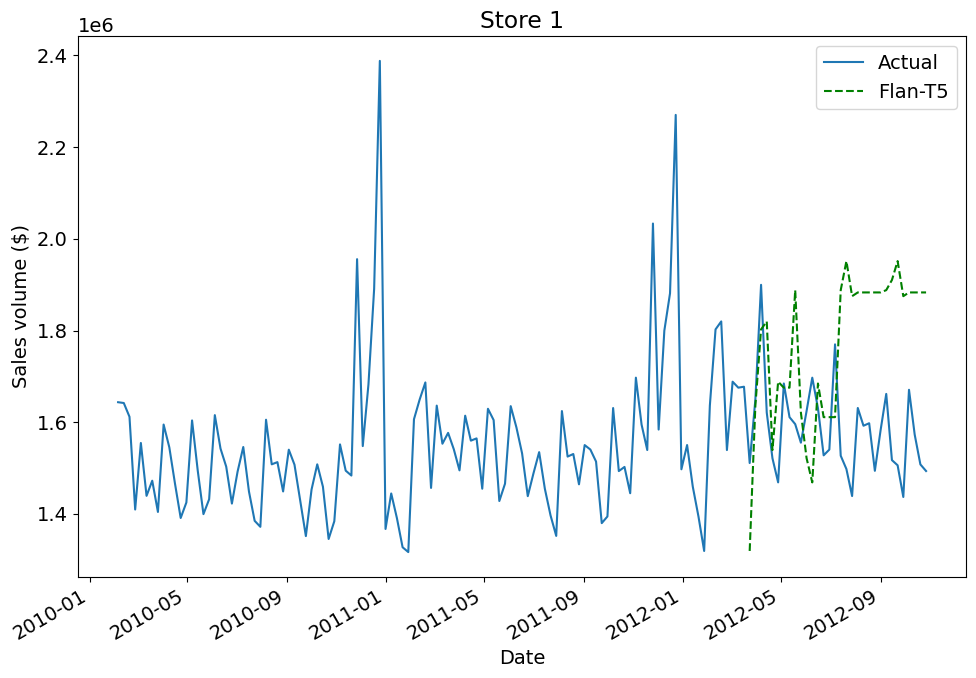

In [18]:
store1_df = data.query("Store == 1")

fig, ax = plt.subplots(figsize=(10,7))

ax.plot(store1_df['Date'], store1_df['Weekly_Sales'], label='Actual')
ax.plot(store1_df['Date'].iloc[-32:], store1_cv_exog, ls='--', color='green', label='Flan-T5')

ax.set_title(f"Store 1")
ax.set_xlabel('Date')
ax.set_ylabel('Sales volume ($)')
ax.legend(loc=1)

fig.autofmt_xdate()
plt.tight_layout()

plt.savefig("figures/CH08_F05_peixeiro2.png", dpi=300)

In [19]:
test_df['FlanT5-exog'] = store1_cv_exog

evaluation = evaluate(
    test_df,
    metrics=[mae, smape],
    models=['FlanT5', 'FlanT5-exog'],
    target_col='Weekly_Sales',
    id_col='Store'
)

evaluation

,Store,metric,FlanT5,FlanT5-exog
0,1,mae,83721.758963,232011.736778
1,1,smape,0.026251,0.068675


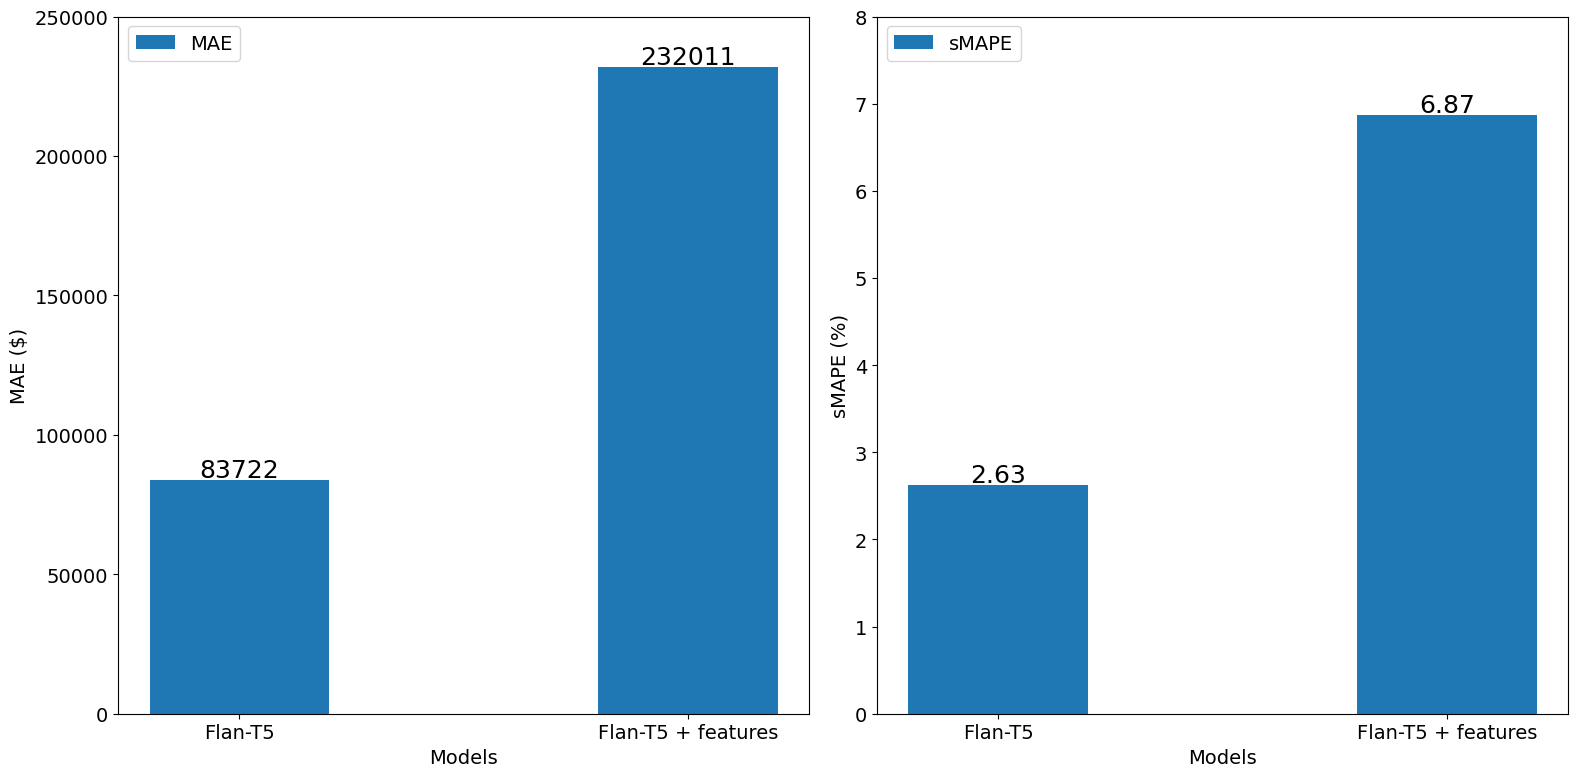

In [20]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16,8))

x = ['Flan-T5', 'Flan-T5 + features']
y_mae = [83722, 232011]
y_smape = [2.63, 6.87]

ax1.bar(x, y_mae, width=0.4, label='MAE')
ax1.set_xlabel('Models')
ax1.set_ylabel('MAE ($)')
ax1.set_ylim(0, 250000)
ax1.legend(loc=2)

for i, v in enumerate(y_mae):
    ax1.text(x=i, y=v+1000, s=str(v), ha='center', fontsize=18)

ax2.bar(x, y_smape, width=0.4, label='sMAPE')
ax2.set_xlabel('Models')
ax2.set_ylabel('sMAPE (%)')
ax2.set_ylim(0, 8)
ax2.legend(loc=2)


for i, v in enumerate(y_smape):
    ax2.text(x=i, y=v+.03, s=str(v), ha='center', fontsize=18)

plt.tight_layout()
plt.savefig("figures/CH08_F06_peixeiro2.png", dpi=300)

## Anomaly detection

In [21]:
df_anomaly = pd.read_csv('../data/nyc_taxi_anomaly_daily.csv', parse_dates=['timestamp'])
df_anomaly.head()

,timestamp,value,is_anomaly
0,2014-07-01,745967,0
1,2014-07-02,733640,0
2,2014-07-03,710142,0
3,2014-07-04,552565,0
4,2014-07-05,555470,0


In [22]:
def detect_anomalies_llm(
    df,
    model,
    tokenizer,
    value_col,
    chunk_size = 10,
    max_new_tokens = 100
):
    # Calculate dataset statistics for context
    mean_value = df[value_col].mean()
    std_value = df[value_col].std()
    q1 = df[value_col].quantile(0.25)
    q3 = df[value_col].quantile(0.75)
    
    anomalies = []
    
    stats_info = f"""Dataset Statistics:
Mean: {mean_value:.2f}
Standard Deviation: {std_value:.2f}
Q1: {q1:.2f}
Q3: {q3:.2f}
"""

    few_shot_examples = f"""For each value, output 1 if it's an anomaly or 0 if it's normal.
Return ONLY a sequence of 0s and 1s separated by commas, with no other text.

Example 1:
Statistics:
Mean: 1000
Q1: 800
Q3: 1200
Values: 900, 1800, 1000, 500, 1100
Anomalies are values that are lower than Q1 or higher than  Q3.
Output: 0,1,0,1,0

Example 2:
Statistics:
Mean: 500
Q1: 400
Q3: 600
Values: 450, 900, 500, 480, 470
Anomalies are values that are lower than Q1 or higher than  Q3.
Output: 0,1,0,0,0

Now analyze these values:"""
    
    for i in range(0, len(df), chunk_size):
        chunk = df.iloc[i:i + chunk_size]
        values_str = ", ".join([f"{x:.2f}" for x in chunk[value_col]])
        
        prompt = f"""{few_shot_examples}

{stats_info}
Values: {values_str}
Anomalies are values that are lower than Q1 or higher than  Q3.

Output exactly {len(chunk)} numbers (0 or 1) separated by commas:"""
        
        inputs = tokenizer(prompt, return_tensors='pt')
        with torch.no_grad():
            output = tokenizer.decode(
                model.generate(
                    inputs["input_ids"],
                    max_new_tokens=max_new_tokens,
                    temperature=0.3,
                    do_sample=False,
                )[0],
                skip_special_tokens=True
            )
        
        print(f"\nProcessing chunk {i//chunk_size + 1}:")
        print(f"Values: {values_str}")
        print(f"Model output: {output}")
        
        # Parse the output and repeat it
        try:
            # Extract the first digit (0 or 1) from the output
            binary_value = next(int(c) for c in output if c in ['0', '1'])
            # Repeat the value for the entire chunk
            binary_values = [binary_value] * len(chunk)
            print(f"Extending {binary_value} to {len(chunk)} values")
            
        except (StopIteration, ValueError) as e:
            print(f"Error parsing output: {e}. Using 0 as default.")
            binary_values = [0] * len(chunk)
        
        anomalies.extend(binary_values)
    
    return anomalies

In [23]:
anomalies_flant5 = detect_anomalies_llm(
    df=df_anomaly,
    model=flant5_model,
    tokenizer=flant5_tokenizer,
    value_col='value'
)


Processing chunk 1:
Values: 745967.00, 733640.00, 710142.00, 552565.00, 555470.00, 550285.00, 636570.00, 726535.00, 748567.00, 761596.00
Model output: 0
Extending 0 to 10 values

Processing chunk 2:
Values: 779020.00, 795013.00, 715651.00, 695729.00, 728331.00, 750480.00, 769302.00, 781336.00, 789771.00, 701268.00
Model output: 0
Extending 0 to 10 values

Processing chunk 3:
Values: 669555.00, 747934.00, 784669.00, 771552.00, 786686.00, 798280.00, 711598.00, 605561.00, 707802.00, 739760.00
Model output: 0
Extending 0 to 10 values

Processing chunk 4:
Values: 760563.00, 769160.00, 781616.00, 699449.00, 662215.00, 710728.00, 737803.00, 754260.00, 758688.00, 743986.00
Model output: 0
Extending 0 to 10 values

Processing chunk 5:
Values: 653183.00, 635503.00, 692472.00, 728588.00, 738931.00, 755739.00, 742592.00, 667964.00, 631430.00, 681756.00
Model output: 0
Extending 0 to 10 values

Processing chunk 6:
Values: 707241.00, 741183.00, 711225.00, 711571.00, 638602.00, 601875.00, 652836.00,

In [24]:
def evaluate_anomaly_detection(df, preds_col, actual_col):
    tp = ((df[preds_col] == 1) & (df[actual_col] == 1)).sum()
    
    tn = ((df[preds_col] == 0) & (df[actual_col] == 0)).sum()
    
    fp = ((df[preds_col] == 1) & (df[actual_col] == 0)).sum()
    
    fn = ((df[preds_col] == 0) & (df[actual_col] == 1)).sum()
    
    precision = tp / (tp + fp) if (tp + fp) != 0 else 0
    
    recall = tp / (tp + fn) if (tp + fn) != 0 else 0
    
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
    
    return precision, recall, f1_score

In [25]:
df_anomaly['flant5'] = anomalies_flant5

precision, recall, f1_score = evaluate_anomaly_detection(df_anomaly, 'flant5', 'is_anomaly')

print(f"Precision: {round(precision,2)}")
print(f"Recall: {round(recall,2)}")
print(f"F1-Score: {round(f1_score,2)}")

Precision: 0
Recall: 0.0
F1-Score: 0


## OpenRouter

In [61]:
OPENROUTER_API_KEY = "use_your_own_key_here"

In [62]:
system_prompt = """
    You are a helpful assistant that performs time series predictions. 
    The user will provide a sequence and you will predict the next sequence. 
    The sequence is represented by decimal numbers as strings separated by commas.
    """

In [63]:
def prompt_forecast(df,
                    horizon,
                    context_len,
                    target_col):
    input_values = df[f'{target_col}'].iloc[-context_len:].values.tolist()

    response = requests.post(
      url="https://openrouter.ai/api/v1/chat/completions",
      headers={
        "Authorization": f"Bearer {OPENROUTER_API_KEY}",
      },
      data=json.dumps({
        "model": "meta-llama/llama-3.2-3b-instruct:free",
        "messages": [
            {
               "role": "system",
                "content": system_prompt
            },
          {
            "role": "user",
            "content": f"The past values of the series are {input_values}. What will be the next {horizon} values? Just output the next values and nothing else."
          }
        ]
        
      })
    )

    response_json = response.json()
    content = response_json['choices'][0]['message']['content']
    if content.startswith('[') and content.endswith(']'):
        preds = json.loads(content)
    else:   
        wrapped = f'[{content}]'
        preds = json.loads(wrapped)
    
    return preds

In [64]:
llama_preds_store1 = prompt_forecast(
    df=data.query("Store == 1"),
    horizon=8,
    context_len=16,
    target_col='Weekly_Sales'
)
llama_preds_store2 = prompt_forecast(
    df=data.query("Store == 2"),
    horizon=8,
    context_len=16,
    target_col='Weekly_Sales'
)
llama_preds_store3 = prompt_forecast(
    df=data.query("Store == 3"),
    horizon=8,
    context_len=16,
    target_col='Weekly_Sales'
)
llama_preds_store4 = prompt_forecast(
    df=data.query("Store == 4"),
    horizon=8,
    context_len=16,
    target_col='Weekly_Sales'
)

all_preds = [llama_preds_store1, llama_preds_store2, llama_preds_store3, llama_preds_store4]

preds_df = combine_predictions(all_preds,
                               start_date='11-02-2012',
                               horizon=8,
                               freq='W-FRI',
                               model_name='Llama')

preds_df.head()

,Store,Date,Llama
0,1,2012-11-02,1672121.83
1,1,2012-11-09,1649269.25
2,1,2012-11-16,1663159.13
3,1,2012-11-23,1601269.28
4,1,2012-11-30,1628609.63


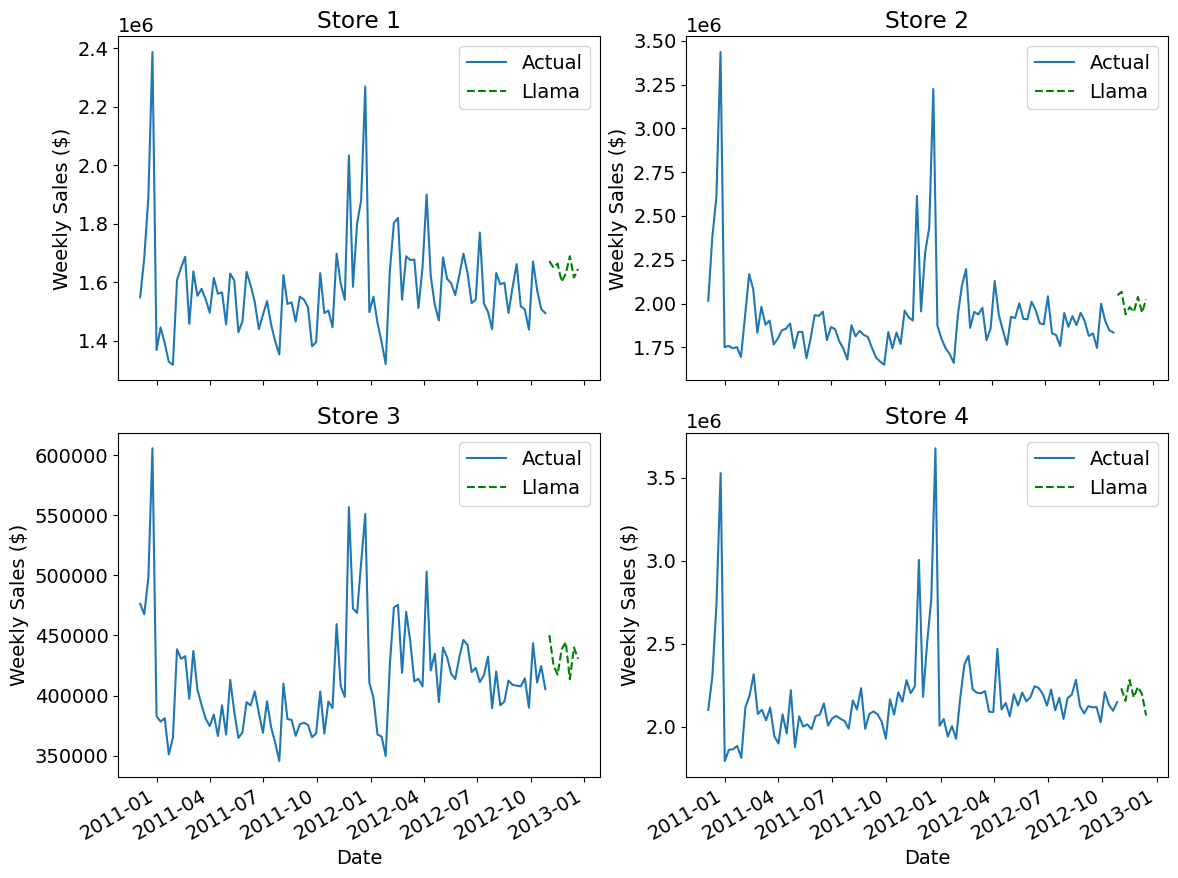

In [65]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,9))

plot_df = data.reset_index(drop=False).copy()
plot_preds_df = preds_df.copy()

for i, ax in enumerate(axes.flatten()):
    df = plot_df[plot_df['Store'] == i+1].iloc[-100:]
    preds_df = plot_preds_df[plot_preds_df['Store'] == i+1]

    ax.plot(df['Date'], df['Weekly_Sales'], label='Actual')
    ax.plot(preds_df['Date'], preds_df['Llama'], 'g--', label='Llama')
    ax.legend()
    ax.set_title(f'Store {i+1}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Weekly Sales ($)')

fig.autofmt_xdate()
plt.tight_layout()
plt.savefig("figures/CH08_F07_peixeiro2.png", dpi=300)

In [66]:
def cross_validation_prompt(df, h, n_windows, target_col):

    preds = []
    
    for i in range(n_windows, 0, -1):
        input_df = df.iloc[:-(h * i)]
        
        forecast = prompt_forecast(input_df,
                                horizon=h,
                                context_len=h,
                                target_col=target_col)
    
        preds.extend(forecast)

    return preds

In [76]:
store1_cv = cross_validation_prompt(
    data.query("Store == 1"),
    h=8,
    n_windows=4,
    target_col='Weekly_Sales'
)

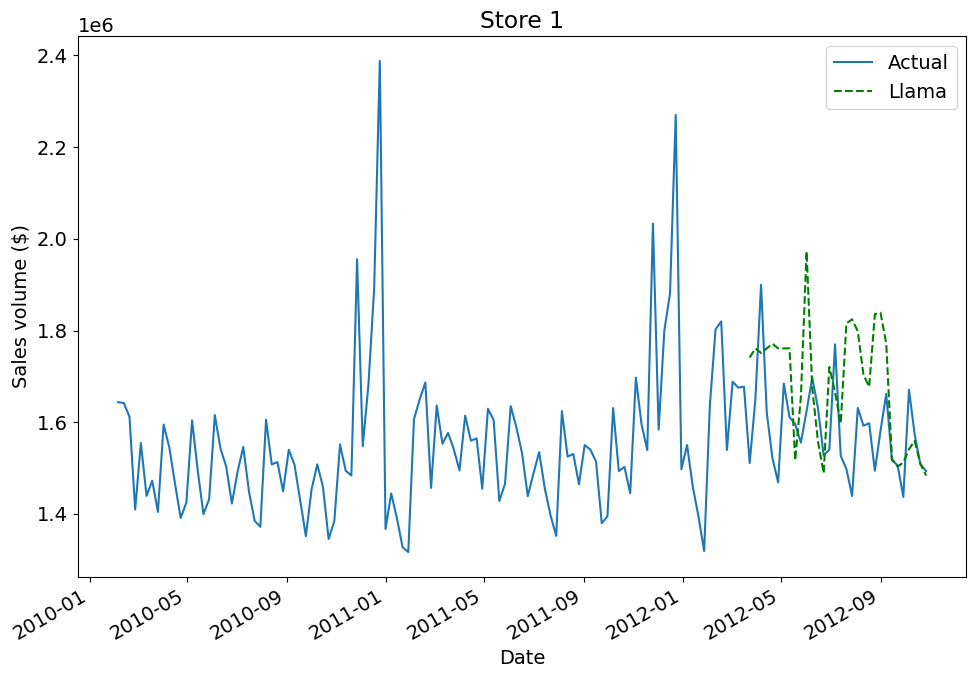

In [77]:
store1_df = data.query("Store == 1")

fig, ax = plt.subplots(figsize=(10,7))

ax.plot(store1_df['Date'], store1_df['Weekly_Sales'], label='Actual')
ax.plot(store1_df['Date'].iloc[-32:], store1_cv[:32], ls='--', color='green', label='Llama')

ax.set_title(f"Store 1")
ax.set_xlabel('Date')
ax.set_ylabel('Sales volume ($)')
ax.legend(loc=1)

fig.autofmt_xdate()
plt.tight_layout()

plt.savefig("figures/CH08_F08_peixeiro2.png", dpi=300)

In [78]:
test_df = data.query("Store == 1").iloc[-32:]
test_df['Llama'] = store1_cv[:32]

evaluation = evaluate(
    test_df,
    metrics=[mae, smape],
    models=['Llama'],
    target_col='Weekly_Sales',
    id_col='Store'
)

evaluation

,Store,metric,Llama
0,1,mae,138051.552187
1,1,smape,0.041501


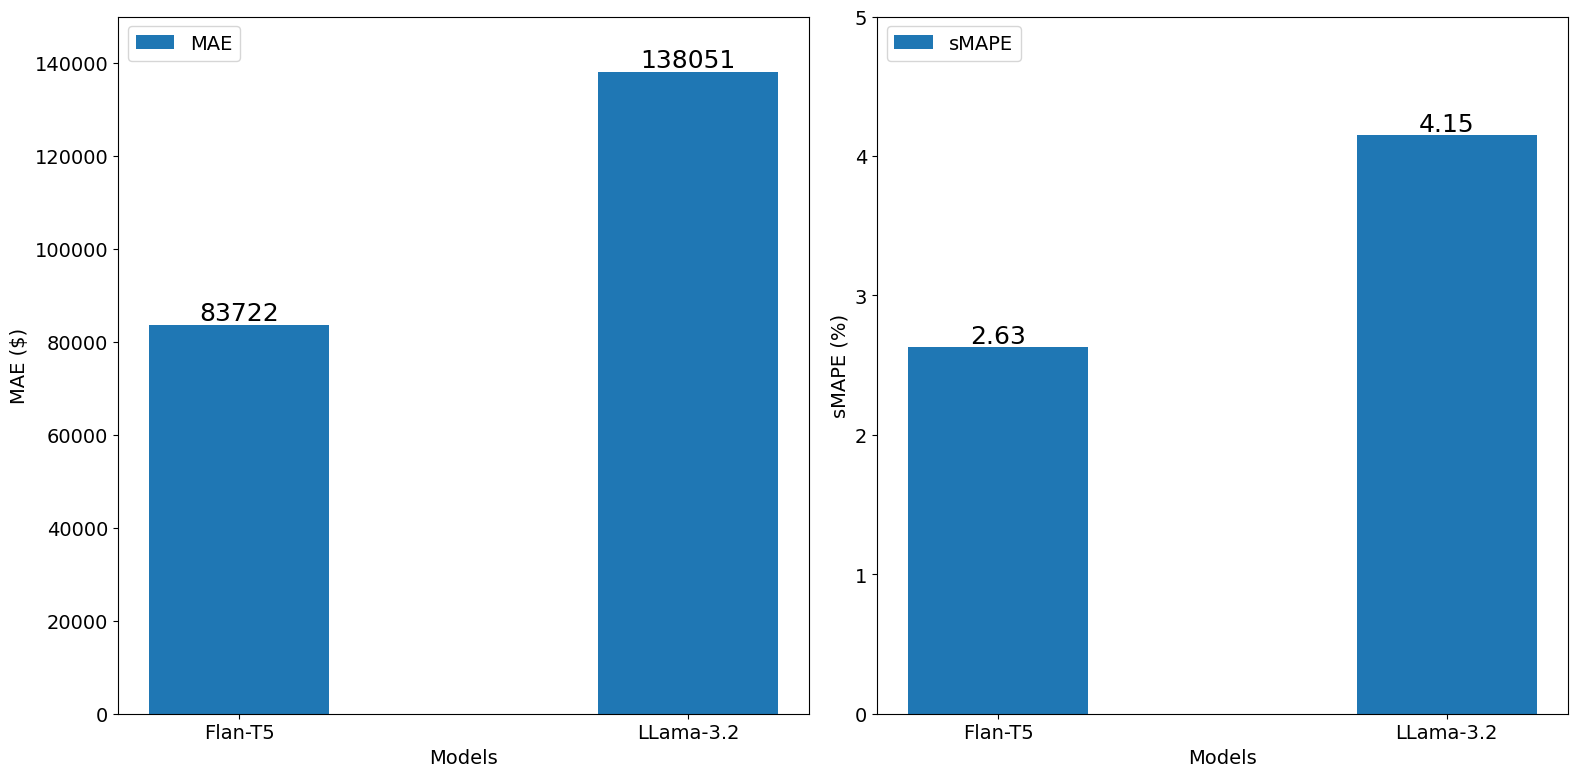

In [80]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16,8))

x = ['Flan-T5', 'LLama-3.2']
y_mae = [83722, 138051]
y_smape = [2.63, 4.15]

ax1.bar(x, y_mae, width=0.4, label='MAE')
ax1.set_xlabel('Models')
ax1.set_ylabel('MAE ($)')
ax1.set_ylim(0, 150000)
ax1.legend(loc=2)

for i, v in enumerate(y_mae):
    ax1.text(x=i, y=v+1000, s=str(v), ha='center', fontsize=18)

ax2.bar(x, y_smape, width=0.4, label='sMAPE')
ax2.set_xlabel('Models')
ax2.set_ylabel('sMAPE (%)')
ax2.set_ylim(0, 5)
ax2.legend(loc=2)


for i, v in enumerate(y_smape):
    ax2.text(x=i, y=v+.03, s=str(v), ha='center', fontsize=18)

plt.tight_layout()
plt.savefig("figures/CH08_F09_peixeiro2.png", dpi=300)

In [54]:
anomaly_system_prompt = """
    You are an expert at identifying anomalous points in a sequence of values.
    The user will provide a sequence of comma-separated values, and you must indicate which one are anomalous (1) or normal (0).
    For example, in the sequence: 1, 1, 1, 1, 1, all points are normal, so the output is [0, 0, 0, 0, 0].
    However, in the sequence: 1, 1, 1, 89, 1, there is one point abnormally large, so the output is [0, 0, 0, 1, 0].
    Similarly, in the sequence 20, 1, 20, 20, 20, there is one point abnomrally small, so the output is [0, 1, 0, 0, 0]
"""
def detect_anomalies_llama(
    df,
    value_col,
    chunk_size
):

    anomalies = []
    
    for i in range(0, len(df), chunk_size):
        chunk = df.iloc[i:i + chunk_size]
        values_str = ", ".join([f"{x:.2f}" for x in chunk[value_col]])

        response = requests.post(
          url="https://openrouter.ai/api/v1/chat/completions",
          headers={
            "Authorization": f"Bearer {OPENROUTER_API_KEY}",
          },
          data=json.dumps({
            "model": "meta-llama/llama-3.2-3b-instruct:free",
            "messages": [
                {
                   "role": "system",
                    "content": anomaly_system_prompt
                },
              {
                "role": "user",
                "content": f"Label each point in the following sequence as normal (0) or abnormal (1): {values_str}. Just output the label."
              }
            ]
            
          })
        )
    
        response_json = response.json()
        content = response_json['choices'][0]['message']['content']
        content = content.strip()
        if not content.startswith('['):
            content = '[' + content
        if not content.endswith(']'):
            content = content + ']'
        anomaly_flags = json.loads(content)[:chunk_size]
        anomalies.extend(anomaly_flags)

    if len(anomalies) < len(df):
        anomalies.extend([0] * (len(df) - len(anomalies)))
        
    return anomalies

In [55]:
llama_anomaly_flag = detect_anomalies_llama(df_anomaly, 'value', 40)

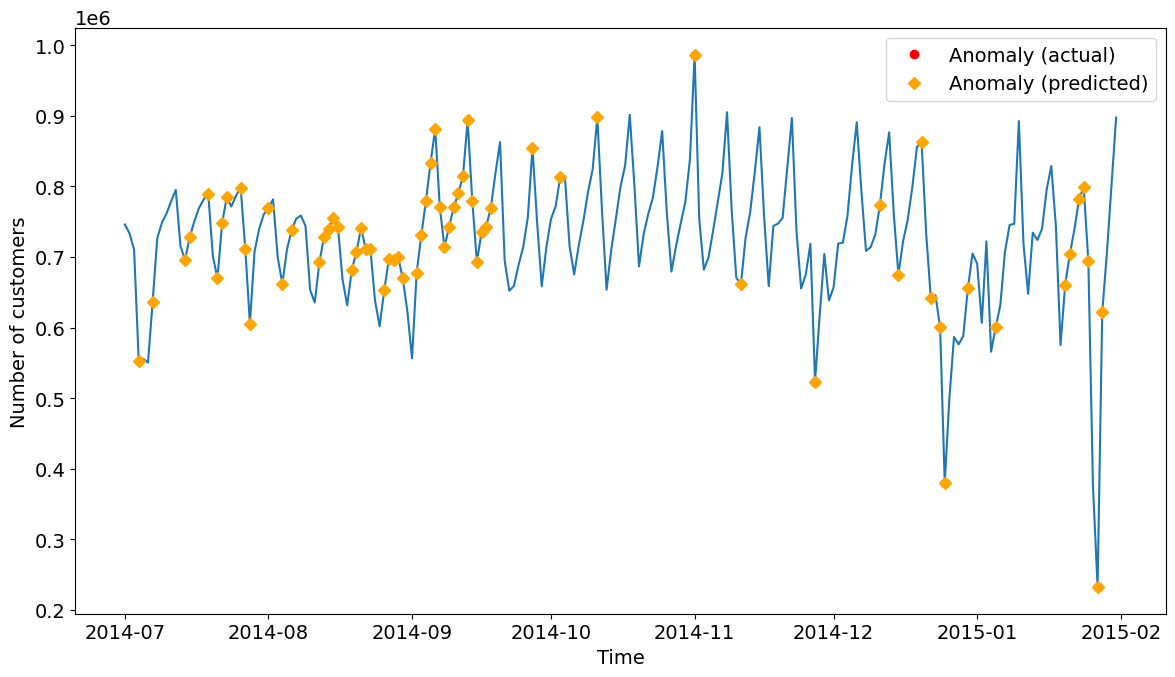

In [56]:
df_anomaly['llama_anomaly'] = llama_anomaly_flag

actual_anomaly_df = df_anomaly.loc[df_anomaly['is_anomaly'] == 1]
pred_anomaly_df = df_anomaly.loc[df_anomaly['llama_anomaly'] == 1] 

fig, ax = plt.subplots(figsize=(12,7))

ax.plot(df_anomaly['timestamp'], df_anomaly['value'])
ax.plot(actual_anomaly_df['timestamp'], actual_anomaly_df['value'], 'o', color='red', label='Anomaly (actual)')
ax.plot(pred_anomaly_df['timestamp'], pred_anomaly_df['value'], 'D', color='orange', label='Anomaly (predicted)')
ax.set_xlabel('Time')
ax.set_ylabel('Number of customers')
ax.legend(loc='best')

plt.tight_layout()
plt.savefig("figures/CH08_F10_peixeiro2.png", dpi=300)

In [57]:
precision, recall, f1_score = evaluate_anomaly_detection(df_anomaly[:184], 'llama_anomaly', 'is_anomaly')

print(f"Precision: {round(precision,2)}")
print(f"Recall: {round(recall,2)}")
print(f"F1-Score: {round(f1_score,2)}")

Precision: 0.05
Recall: 1.0
F1-Score: 0.1


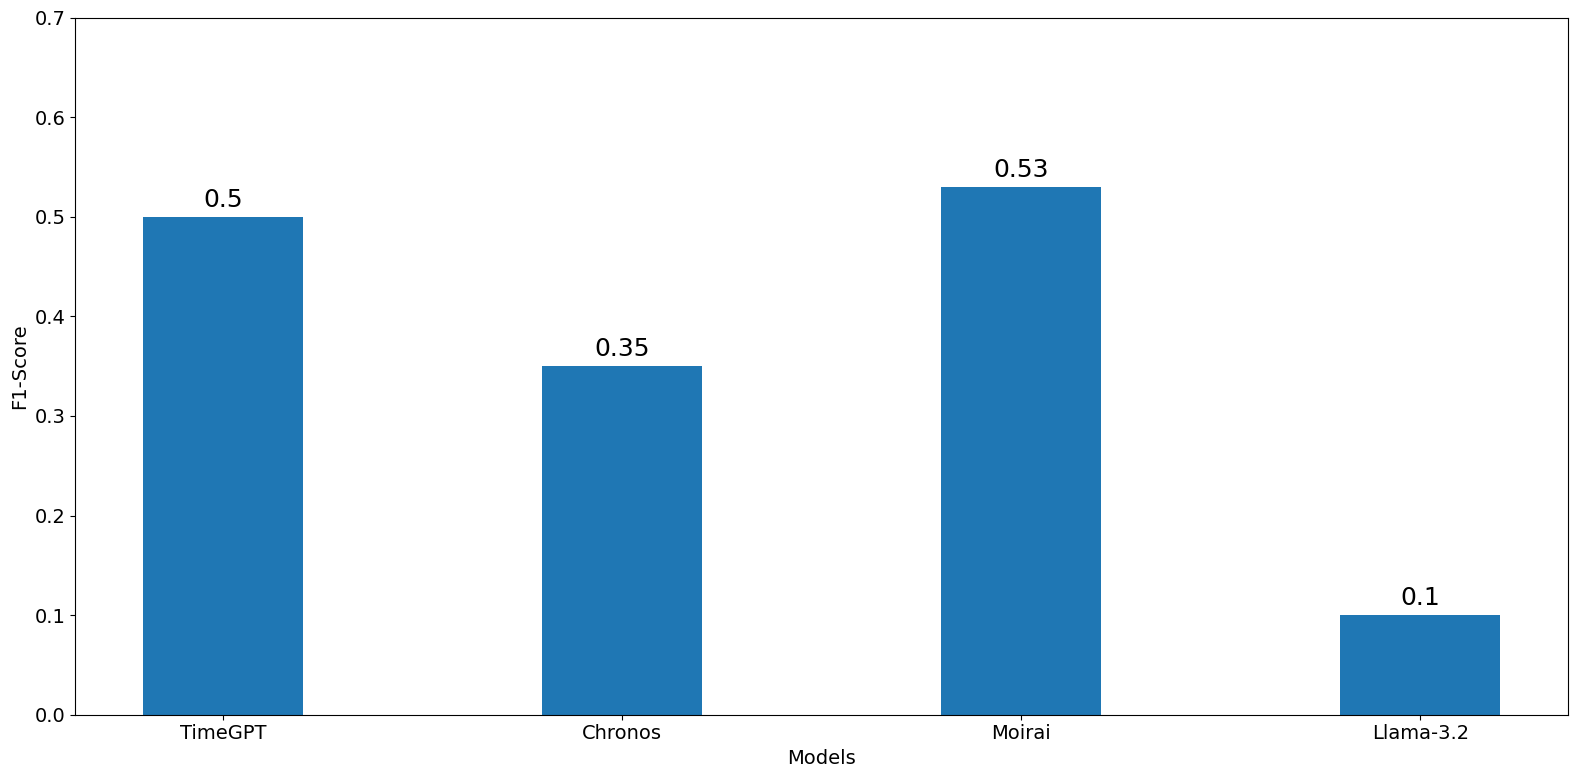

In [59]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,8))

x = ['TimeGPT', 'Chronos', 'Moirai', 'Llama-3.2']
y = [0.50, 0.35, 0.53, 0.10]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Models')
ax.set_ylabel('F1-Score')
ax.set_ylim(0,  0.7)

for i, v in enumerate(y):
    ax.text(x=i, y=v+0.01, s=str(v), ha='center', fontsize=18)

plt.tight_layout()
plt.savefig("figures/CH08_F11_peixeiro2.png", dpi=300)